In [1]:
import json
import numpy as np
from robot_navigation import is_segments_intersect, check_polyline
from matplotlib import pyplot as plt

# solution

In [347]:
def calculateDistance(x1,y1,x2,y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def get_crossed_vec(start, curr_step, obstacles):
    crossed_vec, dists = [], []
    for obs in obstacles:
        for vec1, vec2 in zip(obs, np.vstack([obs[1:], obs[0]])):
            line1 = np.array((vec1, vec2))
            crossed = is_segments_intersect(line1, (start, curr_step))
            if crossed:
                l1 = vec1 - vec2
                l2 = start - curr_step
                l1 = line_intersection((vec1, vec2), (start, curr_step))
                dist = calculateDistance(x1=l1[0], y1=l1[1], x2=start[0], y2=start[1])
                crossed_vec.append(line1)
                dists.append(dist)
#                 print('(start, curr_step) ', (start, curr_step))
#                 print(vec1, vec2, 'dist: ', dist)
    if len(crossed_vec)>0:
        crossed_vec = crossed_vec[np.argmin(dists)]
    return crossed_vec

def get_angle(vec1, vec2):
    norm_v1 = np.linalg.norm(vec1)
    norm_v2 = np.linalg.norm(vec2)
    cosA = np.cross(vec1, vec2)/(norm_v1*norm_v2)
    alpha = np.rad2deg(np.arccos(cosA))
    return alpha

def get_new_direction(crossed_vec, pure_vector):
#     print(crossed_vec)
#     print('\n', pure_vector)
    a, b = crossed_vec
    angleAB = get_angle(pure_vector, b-a)
    angleBA = get_angle(pure_vector, a-b)
#     print(angleAB, angleBA)
    
#     new_dir = b-a if (angleAB<angleBA and ((b-a)>0).any()) else a-b
    new_dir = b-a if (angleAB<angleBA and np.equal(b-a>0, pure_vector>0).any()) else a-b
    new_dir_normed = new_dir/np.linalg.norm(new_dir)
    return new_dir_normed

def get_the_nearest_point(curr_start, finish, next_step):
    dist_to_finish = calculateDistance(curr_start[0], curr_start[1], finish[0], finish[1])
    dist_to_next_point = calculateDistance(curr_start[0], curr_start[1], next_step[0], next_step[1])
    return finish if dist_to_finish < dist_to_next_point else next_step
    
def get_next_step(finish, curr_start, obstacles):
    pure_vector = finish - curr_start
    pure_vector_normed = pure_vector/np.linalg.norm(pure_vector)
    
    next_step = curr_start+pure_vector_normed
    crossed_vec = get_crossed_vec(curr_start, next_step, obstacles)
    
    count_crossed = 0 
    while len(crossed_vec)>0 and count_crossed <= 3:
        print(count_crossed, crossed_vec)
        new_dir_normed = get_new_direction(crossed_vec, pure_vector)
        next_step =  curr_start+new_dir_normed
        crossed_vec = get_crossed_vec(curr_start, next_step, obstacles)
        count_crossed +=1
    else:
        new_dir_normed = pure_vector_normed
    
    curr_start = get_the_nearest_point(curr_start, finish, next_step)
    return curr_start

def plot_path(obstacles, my_path):
    plt.figure(figsize=(15,9))
#     plt.axis('equal')

    for ob in obstacles:
        ob = list(ob)
        ob.append(ob[0])
        x,y = zip(*ob)
        plt.plot(x, y, c='red')

    x,y = zip(*my_path)
    plt.scatter(x, y)
    plt.plot(x,y)
    plt.grid()
    plt.show()

In [348]:
def get_centroid(obstacl):
    return np.array(obstacl).mean(axis=0)


def widther_obstacle(obstacle, width):
    centroid_test = get_centroid(obstacle)
    directions = obstacle-centroid_test
    normed_directions = directions/np.linalg.norm(directions, axis=1)[:, np.newaxis]
    distances = width + np.sqrt(np.sum(directions**2, axis=1))
    new_obstacle = centroid_test + normed_directions*distances[:, np.newaxis]
    return new_obstacle

In [360]:
file = '../data/robot_data.json'
file = '../data/robot-test-25.json'
# file = "../data/robot_my_test.json"

with open(file, 'r') as f:
    data = json.load(f)
    
start, finish = np.array(data['start']), np.array(data['finish'])
obstacles = data['obstacles']
start, finish

(array([10, -1]), array([ 5, 23]))

In [361]:
robot_width = 0.1
obstacles_new = np.array([widther_obstacle(obs, robot_width/2) for obs in obstacles])

curr_start = start
my_path = [curr_start]
max_iteration = 100

while max_iteration >= 0 and (curr_start!=finish).all():
    curr_start = get_next_step(finish, curr_start, obstacles_new)
    my_path.append(curr_start)
    max_iteration -= 1

0 [[9.25762914 2.1208451 ]
 [8.8850614  5.03737546]]
0 [[9.25762914 2.1208451 ]
 [8.8850614  5.03737546]]
0 [[6.97534216 0.48116164]
 [9.25762914 2.1208451 ]]
0 [[6.97534216 0.48116164]
 [9.25762914 2.1208451 ]]
0 [[6.97534216 0.48116164]
 [9.25762914 2.1208451 ]]
0 [[5.21373014 0.37884706]
 [7.63799144 3.3026    ]]
0 [[5.21373014 0.37884706]
 [7.63799144 3.3026    ]]
0 [[5.21373014 0.37884706]
 [7.63799144 3.3026    ]]
0 [[4.26625586 7.58086017]
 [4.96911914 5.00970249]]
0 [[4.26625586 7.58086017]
 [4.96911914 5.00970249]]
0 [[4.26625586 7.58086017]
 [4.96911914 5.00970249]]
0 [[2.42014916 9.26700989]
 [6.57649295 7.1630907 ]]
0 [[2.42014916 9.26700989]
 [6.57649295 7.1630907 ]]
0 [[ 2.81146224 18.31567033]
 [ 4.11835478 15.26841096]]
0 [[ 2.81146224 18.31567033]
 [ 4.11835478 15.26841096]]
1 [[ 3.07697634 16.20649481]
 [ 2.34309502 20.10397166]]
0 [[ 2.81146224 18.31567033]
 [ 4.11835478 15.26841096]]
1 [[ 3.07697634 16.20649481]
 [ 2.34309502 20.10397166]]
2 [[ 2.81146224 18.3156703

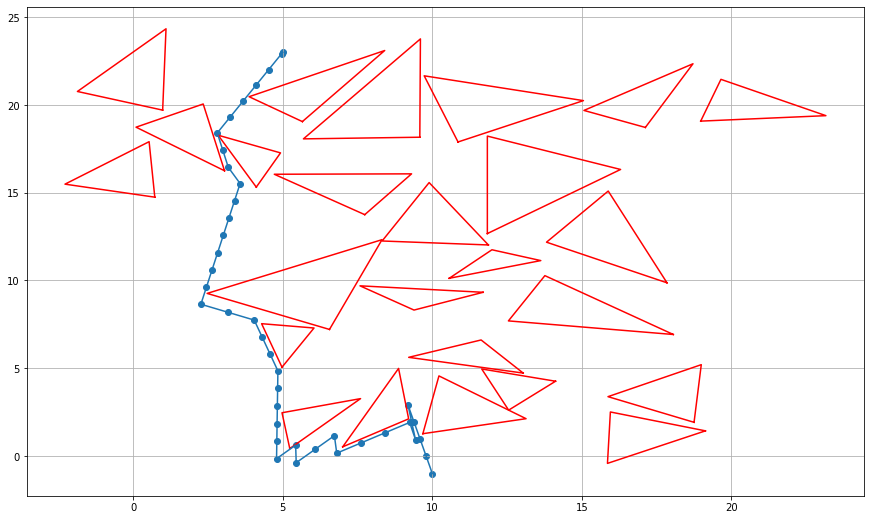

In [362]:
plot_path(obstacles, my_path)

In [363]:
check_polyline(polyline=np.array(my_path), obstacles=np.array([np.array(li) for li in obstacles]))

True